# Discover

For inspiration on EDA for image analysis, I have learned from these notebooks: [SimpleEDA](https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch), [ChannelStats](https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93)

In [0]:
!pip install tensorflow==2.0.0

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
%matplotlib inline
from PIL import Image
import tensorflow as tf
import time
import zipfile
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import keras

In [15]:
tf.version.VERSION

'2.0.0'

In [2]:
from google.colab import files
uploaded = files.upload()



Saving kaggle.json to kaggle.json


In [0]:
root_dir = '/content/competitions/histopathologic-cancer-detection/'
root_logdir = os.path.join(root_dir, "tensorboard_logs")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [30]:
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

!kaggle config set -n path -v '/content/'
!kaggle competitions download histopathologic-cancer-detection

mkdir: cannot create directory ‘histopathologic-cancer-detection’: File exists
- path is now set to: /content/
  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 95.0MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 84.0MB/s]
 99% 1.30G/1.30G [00:07<00:00, 164MB/s]
100% 1.30G/1.30G [00:07<00:00, 176MB/s]
100% 4.96G/4.98G [00:28<00:00, 164MB/s]
100% 4.98G/4.98G [00:28<00:00, 188MB/s]


In [0]:
os.chdir(root_dir)

for path_to_zip_file in os.listdir():
    new_directory = os.path.splitext(path_to_zip_file)[0]
    os.makedirs(new_directory, exist_ok=True)
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
      zip_ref.extractall(new_directory)
      zip_ref.close()

In [57]:
! ls -l | head -10

total 6617132
-rw-r--r-- 1 root root    1394488 Oct 15 17:14 sample_submission.csv.zip
drwxr-xr-x 2 root root    4366336 Oct 15 17:45 test
-rw-r--r-- 1 root root 1401100547 Oct 15 17:14 test.zip
drwxr-xr-x 2 root root   16748544 Oct 15 17:45 train
drwxr-xr-x 2 root root       4096 Oct 15 17:45 train_labels.csv
-rw-r--r-- 1 root root    5352900 Oct 15 17:14 train_labels.csv.zip
-rw-r--r-- 1 root root 5346961539 Oct 15 17:14 train.zip


In [0]:
train_path = os.path.join(root_dir, 'train/')
test_path = os.path.join(root_dir, 'test/')
train_labels_path = os.path.join(root_dir, 'train_labels.csv/train_labels.csv')

In [0]:
train_df = pd.read_csv(train_labels_path)

In [74]:
train_df.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [67]:
print(f'{len(os.listdir(train_path))} pictures in train.')
print(f'{len(os.listdir(test_path))} pictures in test.')

220025 pictures in train.
57458 pictures in test.


## Visualize some images:

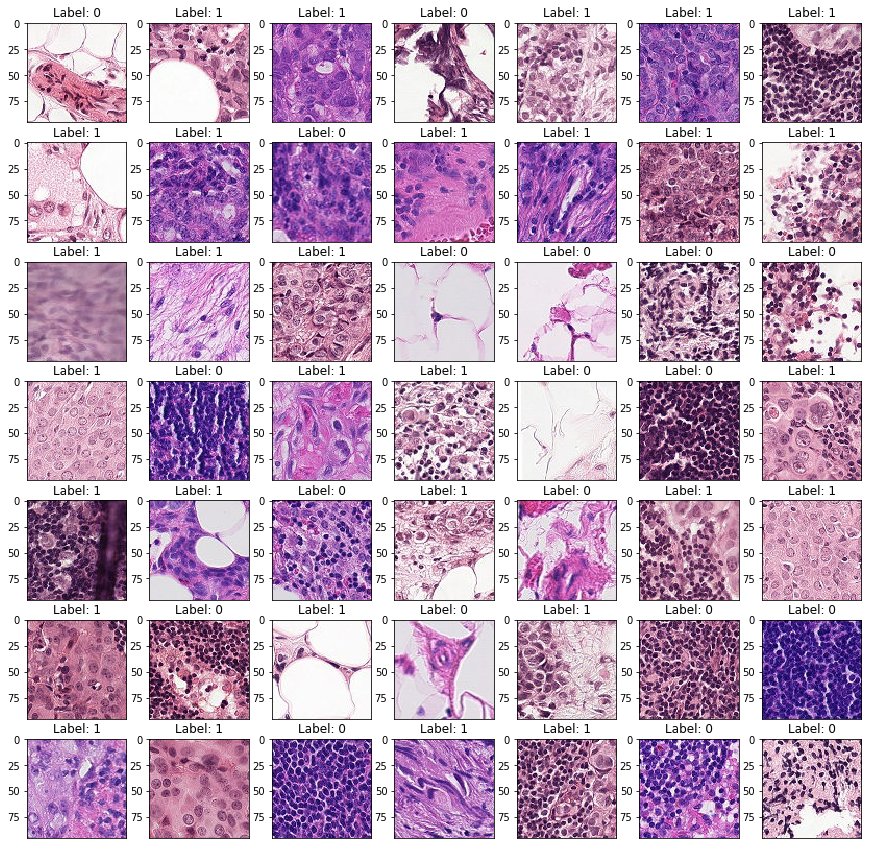

In [75]:
train_set = os.listdir(train_path)
fig, axes = plt.subplots(nrows = 7, ncols = 7, figsize=(15, 15))
axes = axes.reshape(-1)
for idx, img in enumerate(np.random.choice(train_set, 49)):
    im = Image.open(train_path + img)
    axes[idx].imshow(im)
    lab = train_df.loc[labels['id'] == img.split('.')[0], 'label'].values[0]
    axes[idx].set_title(f'Label: {lab}')
    axes[idx].set_xticks([], [])


## Check that the training set is balanced:

In [76]:
train_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [77]:
train_df['label'].value_counts()/sum(train_df['label'].value_counts())

0    0.594969
1    0.405031
Name: label, dtype: float64

## Channel Distributions

In [8]:
train_df['id'] = train_df['id'].apply(lambda x: x+".tif")
train_df = train_df.astype({'label': 'str'})
batch_size = 1
# !!!!!!
train_df = pd.DataFrame(train_df.head(10))

pars = {'dataframe': train_df, 
                'directory': train_path, 
                'x_col': 'id', # filenames of images
                'y_col': 'label', # class
                'target_size': (96, 96),
                'class_mode':'binary', 
                'batch_size': batch_size}

train_data_gen = ImageDataGenerator() 
train_generator = train_data_gen.flow_from_dataframe(**pars)

Found 10 validated image filenames belonging to 2 classes.


In [0]:
n_bins = 256
epochs = train_generator.samples
target_steps = epochs - 1

prog_bar = tf.keras.utils.Progbar(
    target_steps,
    width=30,
    verbose=1,
    interval=0.05,
    stateful_metrics=None,
    unit_name='step'
)
#tf.summary.histogram('my_histogram', train_generator)

In [34]:
run_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(run_logdir)
with writer.as_default():
  for step in range(epochs):
      prog_bar.update(step)
      batches = 0
      #for x_batch, y_batch in train_generator: #train_data_gen.flow(batch_size=32)):
      #    tf.summary.histogram('my_histogram', x_batch, buckets = n_bins, step = step)
      tf.summary.scalar('my_scalar', np.sin(step / 10), step = step)

      writer.flush()
      batches += 1
      if batches >= len(train_df) / batch_size: 
              # we need to break the loop by hand because
              # the generator loops indefinitely
          break

9/9 [==============================] - 3172s 352s/step


In [38]:
run_logdir

'/content/competitions/histopathologic-cancer-detection/tensorboard_logs/run_2019_10_15-22_59_51'

In [39]:
root_logdir

'/content/competitions/histopathologic-cancer-detection/tensorboard_logs'

In [40]:
#! tensorboard --logdir=./tensorboard_logs --port=6006
#%load_ext tensorboard
# using the variable root_logdir was not working here:
%tensorboard --logdir '/content/competitions/histopathologic-cancer-detection/tensorboard_logs'

In [41]:
96*96

9216

In [0]:
!kill 3972

In [25]:
os.chdir(run_logdir)
!ls -l

total 612
-rw-r--r-- 1 root root 622620 Oct 15 22:22 events.out.tfevents.1571178145.b4ae87c1dc32.3177.5913.v2


In [0]:
# FOR ANOTHER TIME (Ie. Modelling)
 # Build and compile your model
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

In [24]:
#tf.summary.histogram('my_histogram', train_generator, None, n_bins)
writer = tf.summary.create_file_writer("/tmp/mylogs")
with writer.as_default():
  for step in range(5):
    prog_bar.update(step)
    data = next(train_generator)
    print(np.shape(data))
    tf.summary.image("my_metric", data, step=step)
    
    #print(next(train_generator))
    #tf.summary.scalar("my_metric", 0.5, step=step)
    writer.flush()

  0/100 [..............................] - ETA: 0s

ValueError: ignored